# Facial Keypoints Detection

In [1]:
# imports
import sys
import copy
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from utils.eda import show_image_with_keypoints, get_image_and_keypoints_from_observation, visualize_duplicates
# preprocessing
from preprocessor.preprocessor import Preprocessor
from torch_dataset.facial_keypoints_dataset import FacialKeypointsDataset
# augmentation
from augmentor.edge_detection.edge_detection import EdgeDetection
from augmentor.image_blurring.image_blurring import ImageBlurring
from augmentor.image_brightness.image_brightness import ImageBrightness
from augmentor.image_flip.image_flip import ImageFlip
from augmentor.image_rotation.image_rotation import ImageRotation
from augmentor.image_sharpening.image_sharpening import ImageSharpening
from augmentor.image_translation.image_translation import ImageTranslation
from augmentor.image_to_tensor.image_to_tensor import ImageToTensor

## Load data

In [2]:
df_train = pd.read_csv('../data/training.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
df_train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [4]:
df_test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


## Exploratory Data Analysis

### Basic info

In [5]:
print('shape of train dataset: ', df_train.shape)
print('shape of test dataset: ', df_test.shape)

shape of train dataset:  (7049, 31)
shape of test dataset:  (1783, 2)


Columns and their types in df_train:

-left(right)_eye_center_x(y) - x(y) coordinate of location of center of left(right) eye on image - float,

-left(right)_eye_inner_corner_x(y) - x(y) coordinate of location of inner corner of left(right) eye - float,

-left(right)_eye_outer_corner_x(y) - x(y) coordinate of location of outer corner of left(right) eye - float,

-left(right)_eyebrow_inner_end_x(y) - x(y) coordinate of location of inner end of left(right) eyebrow - float,

-left(right)_eyebrow_outer_end_x(y) - x(y) coordinate of location of outer end of left(right) eyebrow - float,

-nose_tip_x(y) - x(y) coordinate of tip of nose - float,

-mouth_left(right)_corner_x(y) - x(y) coordinate of location of left(right) corner of mouth - float,

-mouth_center_top(bottom)_lip_x(y) - x(y) coordinate of top(bottom) center of mouth - float,

-Image - matrix representing image - matrix

### Example visualisation

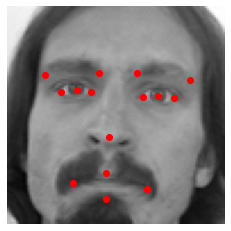

In [6]:
images, keypoints = get_image_and_keypoints_from_observation(df_train.iloc[0], preprocess=True)
show_image_with_keypoints(images, keypoints)

### Missing values

In [7]:
df_train.isna().sum().sort_values(ascending=False)

left_eyebrow_outer_end_y     4824
left_eyebrow_outer_end_x     4824
right_eyebrow_outer_end_y    4813
right_eyebrow_outer_end_x    4813
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
mouth_left_corner_y          4780
mouth_left_corner_x          4780
right_eyebrow_inner_end_x    4779
mouth_right_corner_x         4779
right_eyebrow_inner_end_y    4779
left_eyebrow_inner_end_y     4779
left_eyebrow_inner_end_x     4779
mouth_right_corner_y         4779
left_eye_inner_corner_y      4778
left_eye_inner_corner_x      4778
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_y      33
mouth_center_bottom_lip_x      33
right_eye_center_y             13
right_eye_center_x             13
left_eye_center_x              10
left_eye_center_y              10
nose_tip_y                      0
nose_tip_x    

There are a lot of missing values in the data, especially in more sophisticated features. We can impute them using other resnet18s, or just ignore the value of loss function for them. Since all the missing values appear in target variables, for now we will not impute them, and rather just omit calculating loss for these observations. Hence, no actions will be taken as of now.

In [8]:
def MSELoss(output, target):
    filter = ~torch.isnan(target)
    return ((output[filter] - target[filter]) ** 2).mean()

### Duplicates

In [9]:
duplicates_count = df_train.duplicated(subset = 'Image', keep='last').sum()
print(f'There are {duplicates_count} duplicates in the dataset.')

There are 555 duplicates in the dataset.


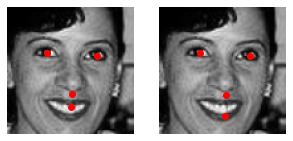

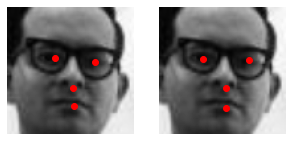

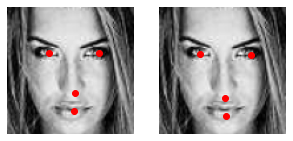

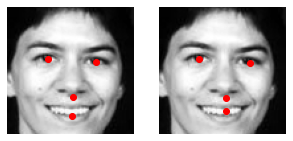

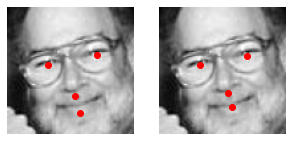

In [10]:
visualize_duplicates(df_train)

There is no clear automatic way of picking better option. Thus, the best way would be to calculate some sort of aggregate for every feature. For lack of a better candidate, let's go with the mean value.

## Preprocessing

In [11]:
preprocessor_train = Preprocessor(df_train)
preprocessor_test = Preprocessor(df_test)

In [12]:
print('Preprocessing train dataset..')
preprocessor_train.preprocess_dataset()
df_train = preprocessor_train.df

Preprocessing train dataset..
Handling duplicates...done.
Transforming image column...done.


In [13]:
print('Preprocessing test dataset..')
df_test = preprocessor_test.preprocess_dataset()
df_test = preprocessor_test.df

Preprocessing test dataset..
Handling duplicates...done.
Transforming image column...done.


In [14]:
print("shape of the train dataset after preprocessing: ", df_train.shape)
print("shape of the test dataset after preprocessing: ", df_test.shape)

shape of the train dataset after preprocessing:  (6494, 31)
shape of the test dataset after preprocessing:  (1752, 2)


### Visualizations after preprocessing

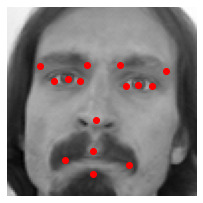

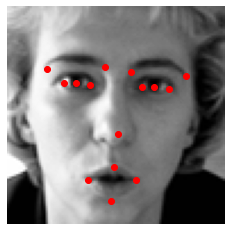

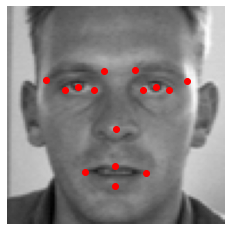

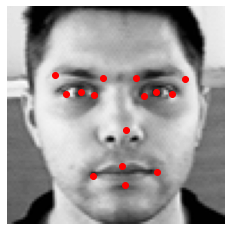

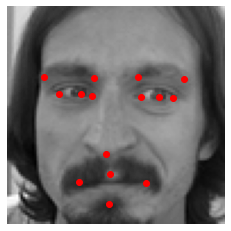

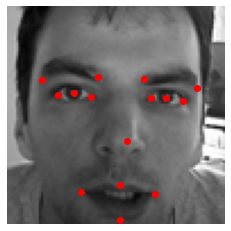

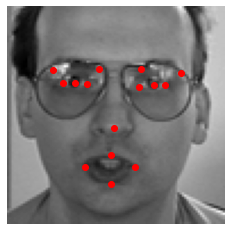

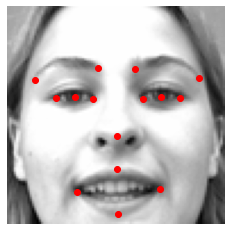

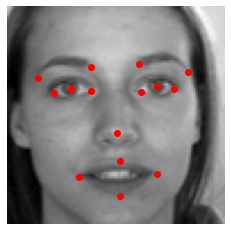

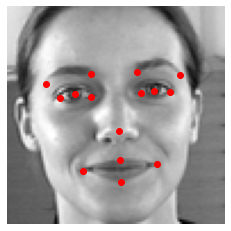

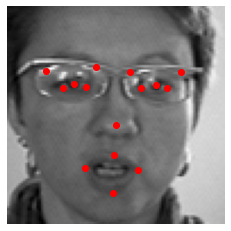

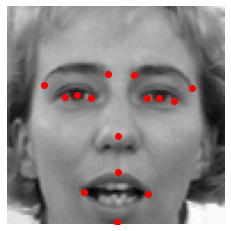

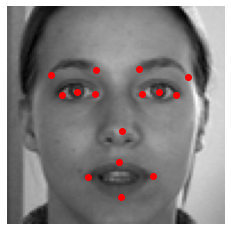

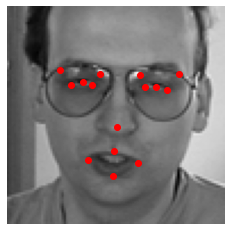

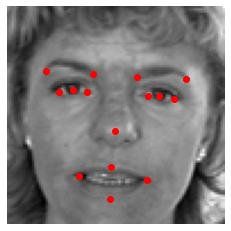

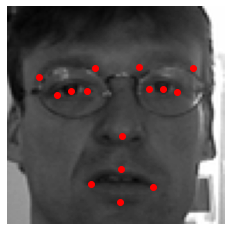

In [15]:
fig = plt.figure(figsize=(16,16))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    image, keypoints = get_image_and_keypoints_from_observation(df_train.iloc[i])
    show_image_with_keypoints(image, keypoints)

## Creating torch dataset

Number of observations in training set:  6494


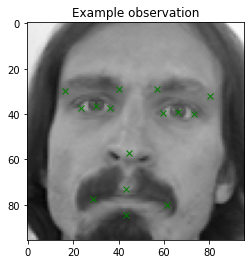

In [16]:
dataset = FacialKeypointsDataset(df_train)
print("Number of observations in training set: ", len(dataset))
datapoint = dataset[0]
img = datapoint['image']
keypoints = datapoint['keypoints']
plt.imshow(img, cmap='gray')
plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
plt.title("Example observation")
plt.show()

## Data augmentation

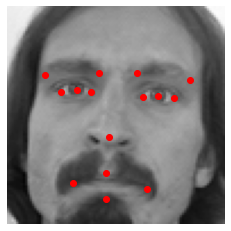

In [17]:
show_image_with_keypoints(datapoint["image"], datapoint["keypoints"].reshape(15,2))

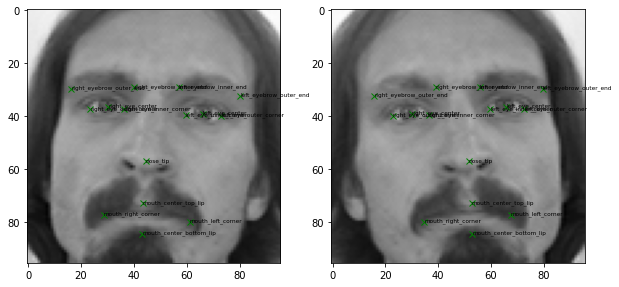

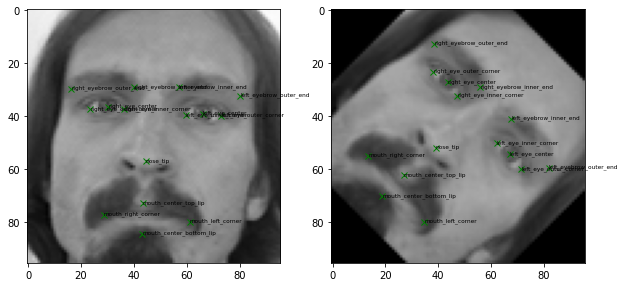

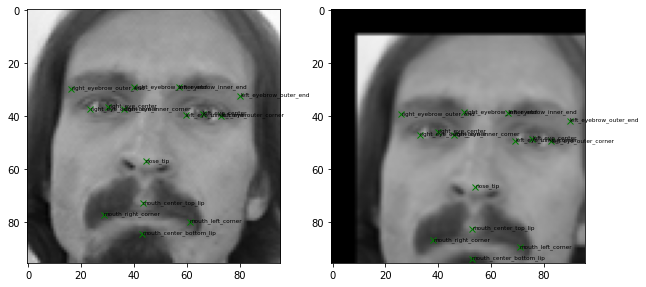

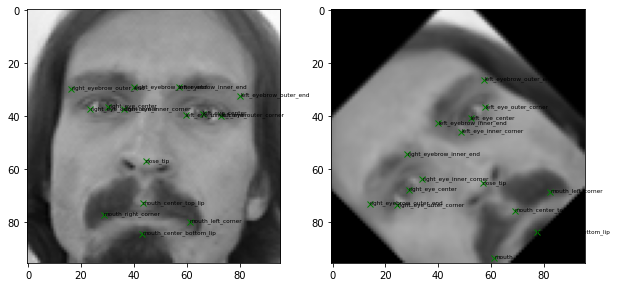

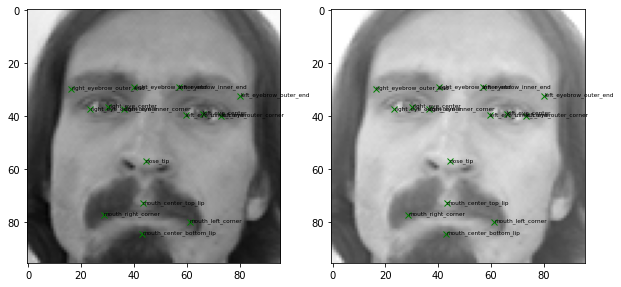

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


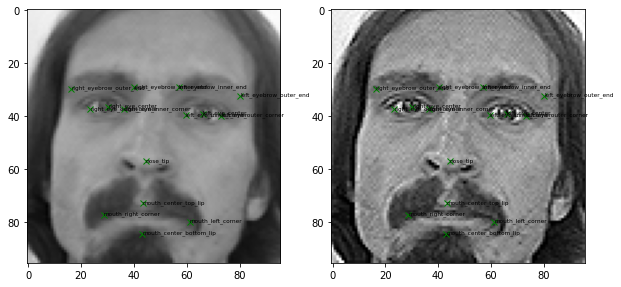

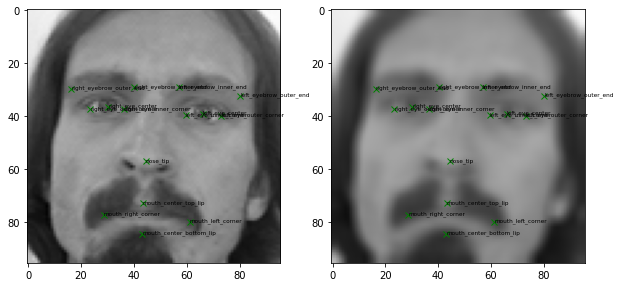

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


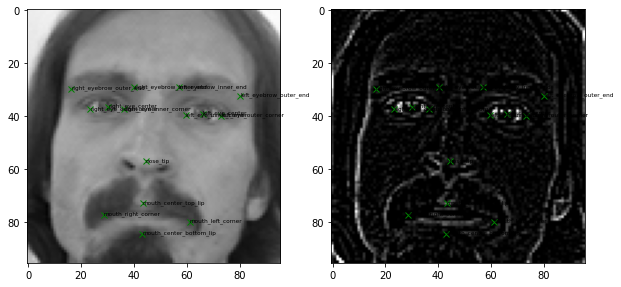

In [18]:
image, keypoints = datapoint["image"], datapoint["keypoints"]
keypoints_columns = df_train.columns[:-1]
random_flip = ImageFlip(probability_threshold=1.0)
random_rotation = ImageRotation(angle=45, probability_threshold=1.0)
random_translation = ImageTranslation(translation_params = (0.1, 0.1), probability_threshold=1.0)
random_brightness = ImageBrightness(brightness=0.2, probability_threshold=1.0)
random_sharpening = ImageSharpening(probability_threshold=1.0)
random_blurring = ImageBlurring(ksize = (5, 5), probability_threshold=1.0)
random_edge_sharpening = EdgeDetection(probability_threshold=1.0)

transform_flip = random_flip(datapoint)
transform_rotation = random_rotation(datapoint)
transform_translation = random_translation(datapoint)
transform_combined = random_flip(random_rotation(random_translation(datapoint)))
transform_brightness = random_brightness(datapoint)
transform_sharpening = random_sharpening(datapoint)
transform_blurring = random_blurring(datapoint)
transform_edge_sharpening = random_edge_sharpening(datapoint)

transforms_list = [transform_flip, transform_rotation, transform_translation, transform_combined, transform_brightness, transform_sharpening,
                   transform_blurring, transform_edge_sharpening]

for transformed_image_with_keypoints in transforms_list:
    transformed_image = transformed_image_with_keypoints["image"]
    transformed_keypoints = transformed_image_with_keypoints["keypoints"]

    fig = plt.figure(figsize=(10, 20))
    # Plot original image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    for i, keypoint_name in enumerate(keypoints_columns[::2]):
        plt.annotate(keypoint_name[:-2],
                     (keypoints[2 * i], keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(keypoints.reshape((15, 2))[:, 0],
             keypoints.reshape((15, 2))[:, 1], 'gx')
    # Plot flipped image
    fig.add_subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    for i, keypoint_name in enumerate(keypoints_columns[::2]):
        plt.annotate(keypoint_name[:-2],
                     (transformed_keypoints[2 * i], transformed_keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(transformed_keypoints.reshape((15, 2))[:, 0],
             transformed_keypoints.reshape((15, 2))[:, 1], 'gx')

    plt.show()

### Transformations

In [19]:
train_transform = torchvision.transforms.Compose([
     EdgeDetection(probability_threshold=0.33),
     ImageBlurring(ksize = (5, 5), probability_threshold=0.25),
     ImageBrightness(brightness=0.2, probability_threshold=0.5),
     ImageFlip(probability_threshold=0.5),
     ImageRotation(angle=45, probability_threshold=0.33),
     ImageSharpening(probability_threshold=0.5),
     ImageTranslation(translation_params = (0.1, 0.1), probability_threshold=0.33),
     ImageToTensor()
     ])

val_transform = torchvision.transforms.Compose([ImageToTensor()])
test_transform = torchvision.transforms.Compose([ImageToTensor()])


## Modeling

In [20]:
# training parameters
BATCH_SIZE = 64
EPOCHS = 100
EPOCHS_PRETRAIN = 25

### Dataset preparation

In [21]:
train_size = int(len(dataset) * 0.85)
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_set.dataset.transforms = train_transform
val_set.dataset.transforms = val_transform

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### ResNet18

In [31]:
resnet18 = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)

resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 30)

resnet18 = resnet18.type(torch.FloatTensor)
resnet18 = resnet18.to(device)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

### Pretraining
Before training the whole model, we need to train the last fully connected layer we added for classification.

In [24]:
# turning off the gradient descent training for every layer except for the last one
*previous_layers, last_layer = resnet18.parameters()
for layer in previous_layers:
    layer.requires_grad = False

In [25]:
# set optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.1, weight_decay=0.001)

In [26]:
logger = {'train': [], 'val': []}

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS_PRETRAIN):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS_PRETRAIN}")

    resnet18.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = resnet18(x)
        loss = MSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

    with torch.no_grad():
        resnet18.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = resnet18(x)
            val_loss += MSELoss(pred, y)

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")


logger_df_pretrained = pd.DataFrame(logger)

EPOCH: 1/25
Average train loss: 13237.758789, Average validation loss: 2055.995850
EPOCH: 2/25


KeyboardInterrupt: 

Now, after the preparation of the last fully connected layer, we can train the entire resnet18.

### Training

In [ ]:
# turning the training mode on in previous layers
for layer in previous_layers:
    layer.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0005, weight_decay=0.00005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 25, 40, 65], gamma=0.1)

In [ ]:
logger = {'train': [], 'val': []}


best_model = None
min_val_loss = np.inf

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS}")

    resnet18.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = resnet18(x)
        loss = MSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

    with torch.no_grad():
        resnet18.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = resnet18(x)
            val_loss += MSELoss(pred, y)

    scheduler.step()

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")
    
    if min_val_loss > val_loss:
        min_test_loss = val_loss
        best_model = copy.deepcopy(resnet18)


logger_df = pd.DataFrame(logger)

### Evaluation

#### Loss visualization

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(logger_df["train"]*train_steps/len(train_set), label="train_loss")
plt.plot(logger_df["val"]*val_steps/len(val_set), label="val_loss")
plt.title("Training loss for ResNet-18")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
print('minimum value of the function loss on validation data set: ', min(logger_df["val"]))
# print(logger_df)

## Model inference

In [ ]:
#### Showcase on train set

In [ ]:
IMAGES_TO_SHOW = 10
train_images_idxs = np.random.randint(0, len(train_set) - 1, 10)
transform = ImageToTensor()
best_model.eval()
for idx in train_images_idxs:
    sample = val_set[idx]
    image = sample['image'].to(device)
    keypoints = sample['keypoints']
    with torch.no_grad():
        pred_keypoints = best_model(image.unsqueeze(0)).cpu().detach().numpy().reshape((30,))
    
    plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.plot(pred_keypoints[0::2], pred_keypoints[1::2], 'wo')
    plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
    plt.show()

In [ ]:
#### Showcase on validation set

In [ ]:
IMAGES_TO_SHOW = 10
val_images_idxs = np.random.randint(0, len(val_set) - 1, 10)
transform = ImageToTensor()
best_model.eval()
for idx in val_images_idxs:
    sample = val_set[idx]
    image = sample['image'].to(device)
    keypoints = sample['keypoints']
    with torch.no_grad():
        pred_keypoints = best_model(image.unsqueeze(0)).cpu().detach().numpy().reshape((30,))
    
    plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.plot(pred_keypoints[0::2], pred_keypoints[1::2], 'wo')
    plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
    plt.show()